In [1]:
from lionagi.core.message import System, Instruction
from lionagi.core.executor.graph_executor import GraphExecutor
from lionagi.core.engine.instruction_map_engine import InstructionMapEngine
from lionagi.core.agent.base_agent import BaseAgent

from lionagi.core.action import func_to_tool, DirectiveSelection

# Create Nodes

In [2]:
sys_mul = System("you are asked to perform as a function picker and parameter provider")
instruction = Instruction(
    "Think step by step, understand the following basic math question and provide parameters for function calling."
)

Instruction nodes can link to Tool nodes, specifing the tool or tools to be used in that step

In [3]:
def multiply(number1: float, number2: float):
    """
    Perform multiplication on two numbers.

    Args:
        number1: First number to multiply.
        number2: Second number to multiply.

    Returns:
        The product of number1 and number2.

    """
    return number1 * number2


tool_m = func_to_tool(multiply)

Each Instruction node can link to an ActionSelection node. The supported actions include `chat`, `followup`, or `ReAct`. If no action is attached, the default execution mode is set to `chat`.

In [4]:
action = DirectiveSelection(
    directive="direct", directive_kwargs={"reason": True, "score": True}
)

# Create Structure

In [5]:
graph_mul = GraphExecutor()
graph_mul.add_node(sys_mul)
graph_mul.add_node(instruction)
graph_mul.add_node(tool_m[0])
graph_mul.add_node(action)
graph_mul.add_edge(sys_mul, instruction)
graph_mul.add_edge(instruction, tool_m[0])
graph_mul.add_edge(instruction, action)

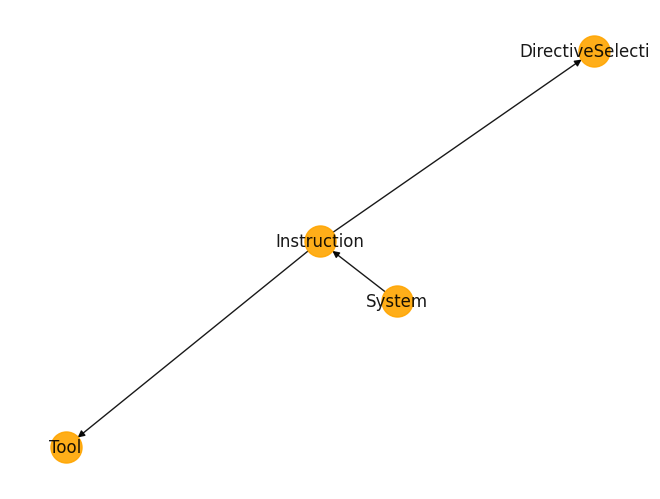

In [6]:
graph_mul.display()

In [7]:
# output_parser parameter: agent self
# output_parser return: the expected result that should be returned after execution
def output_parser(agent):
    ## return all message dataframe in all branches
    output = []
    for branch in agent.executable.branches.values():
        output.append(branch.to_df())
    return output


executable = InstructionMapEngine()

In [8]:
calc = BaseAgent(
    structure=graph_mul,
    executable=executable,
    output_parser=output_parser,
)

# Usage

In [9]:
question1 = "A school is ordering laptops for its students. If each classroom has 25 students and the school wants to provide a laptop for each student in its 8 classrooms, how many laptops in total does the school need to order?"
question2 = "A bakery sells cupcakes in boxes of 6. If a customer wants to buy 8 boxes, with each person getting one cupcake, how many people can the customer serve cupcake to?"

import json

context = {"Question1": question1, "question2": question2}
context = json.dumps(context)

In [10]:
calc_result = await calc.execute(context)

------------------Welcome: system--------------------


system: you are asked to perform as a function picker and parameter provider

user: Think step by step, understand the following basic math question and provide parameters for function calling.

assistant 03ab154c441fd3419c6fccce46bbd344:


task: 
Follow the prompt and provide the necessary output.
- Additional instruction: Think step by step, understand the following basic math question and provide parameters for function calling.
- Additional context: {"Question1": "A school is ordering laptops for its students. If each classroom has 25 students and the school wants to provide a laptop for each student in its 8 classrooms, how many laptops in total does the school need to order?", "question2": "A bakery sells cupcakes in boxes of 6. If a customer wants to buy 8 boxes, with each person getting one cupcake, how many people can the customer serve cupcake to?"}
- Reason and prepare actions with GIVEN TOOLS ONLY.
- Give a numeric score in [0, 10] and precision of 0 decimal places.



reason: 
Let's think step by step. For Question 1, the school has 8 classrooms, each with 25 students. To find the total number of laptops needed, we multiply the number of classrooms by the number of students per classroom: 8 * 25 = 200. For Question 2, the bakery sells cupcakes in boxes of 6, and the customer wants to buy 8 boxes. To find the total number of cupcakes, we multiply the number of boxes by the number of cupcakes per box: 8 * 6 = 48. Therefore, the customer can serve cupcakes to 48 people.


actions: 
{'action_1': {'function': 'multiply', 'arguments': {'number1': 8, 'number2': 25}}, 'action_2': {'function': 'multiply', 'arguments': {'number1': 8, 'number2': 6}}}


action_required: 
True


answer: 
The school needs to order 200 laptops. The customer can serve cupcakes to 48 people.


score: 
10


tool_schema: 
{'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'Perform multiplication on two numbers.', 'parameters': {'type': 'object', 'properties': {'number1': {'type': 'number', 'description': 'First number to multiply.'}, 'number2': {'type': 'number', 'description': 'Second number to multiply.'}}, 'required': ['number1', 'number2']}}}]}


action_response: 
{'action_1': {'function': 'multiply', 'arguments': {'number1': 8, 'number2': 25}, 'output': 200}, 'action_2': {'function': 'multiply', 'arguments': {'number1': 8, 'number2': 6}, 'output': 48}}


action_performed: 
True


-----------------------------------------------------


In [11]:
calc_result[0]

,ln_id,message_type,timestamp,role,content,metadata,sender,recipient
0,5c090f2b691a7432c1ce2bb19c5d7196,System,2024-05-24T00:50:26.416241,system,{'system_info': 'you are asked to perform as a...,{'last_updated': {'recipient': '2024-05-24T00:...,system,03ab154c441fd3419c6fccce46bbd344
1,e80cbc9dccdf66f1805a543dc64df7eb,Instruction,2024-05-24T00:50:27.513841,user,{'instruction': ' ## Task Instructions...,{'last_updated': {'sender': '2024-05-24T00:50:...,user,03ab154c441fd3419c6fccce46bbd344
2,9663ae2c38494ae138794408f9f020e9,AssistantResponse,2024-05-24T00:50:31.867813,assistant,"{'assistant_response': '```json { ""answer""...",{'last_updated': {'sender': '2024-05-24T00:50:...,03ab154c441fd3419c6fccce46bbd344,user
3,e2d61665d2f73c3c1832f62886d4ff76,ActionRequest,2024-05-24T00:50:31.870603,assistant,"{'action_request': {'function': 'multiply', 'a...",{'last_updated': {'function': '2024-05-24T00:5...,03ab154c441fd3419c6fccce46bbd344,2dfb7107f2ae5553d7dac3e3da4ed2cc
4,699db784c21d7a5e17708e57b88fa820,ActionRequest,2024-05-24T00:50:31.870792,assistant,"{'action_request': {'function': 'multiply', 'a...",{'last_updated': {'function': '2024-05-24T00:5...,03ab154c441fd3419c6fccce46bbd344,2dfb7107f2ae5553d7dac3e3da4ed2cc
5,707a283b35fd7d3224793c105287e729,ActionResponse,2024-05-24T00:50:31.871198,assistant,"{'action_response': {'function': 'multiply', '...",{'last_updated': {'function': '2024-05-24T00:5...,2dfb7107f2ae5553d7dac3e3da4ed2cc,03ab154c441fd3419c6fccce46bbd344
6,4efc00174cc8fc048b4807911afadf9f,ActionResponse,2024-05-24T00:50:31.871386,assistant,"{'action_response': {'function': 'multiply', '...",{'last_updated': {'function': '2024-05-24T00:5...,2dfb7107f2ae5553d7dac3e3da4ed2cc,03ab154c441fd3419c6fccce46bbd344


# Storing Structures

We currently support the storage of structures in Excel and Neo4j, enabling their reuse in future applications.

### Excel

In [12]:
graph_mul.to_excel("tool_mul")  # dir = "structure_storage" (default)

### Neo4j

In [13]:
# initiate Neo4j Driver
uri = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"
database = "neo4j"

from lionagi.integrations.storage.neo4j import Neo4j

neo4j = Neo4j(uri, user, password, database)

In [14]:
# structure_name is unique

await neo4j.store(graph_mul, structure_name="tool_mul")